# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

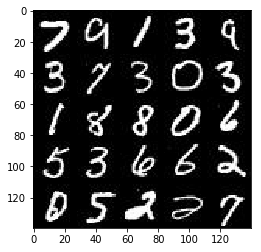

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

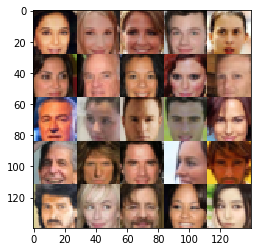

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, shape=[], name='lr')

    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha=0.2
        #print('discriminator input: {}'.format(images.shape))
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(x1.shape)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(x2.shape)
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(x3.shape)
        # 7x7x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #print('discriminator output: {}'.format(flat.shape))
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [20]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        # First fully connected layer
        x = tf.layers.dense(z, 3*3*256)
        # Reshape it to start the convolutional stack
        x = tf.reshape(x, (-1, 3, 3, 256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x1.shape)
        # 7x7x512 now
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=1, padding='valid')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x2.shape)
        # 7x7x256 now
        
        #x = tf.layers.conv2d_transpose(x, 128, 4, strides=1, padding='same')
        #x = tf.layers.batch_normalization(x, training=is_train)
        #x = tf.maximum(alpha * x, x)
        #print(x3.shape)
        # 7x7x256 now
        
        x = tf.layers.conv2d_transpose(x, 64, 4, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        #print(x4.shape)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 4, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        #print('generator output: {}'.format(out.shape))   
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 50
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.2727... Generator Loss: 1.8782
Epoch 0/2... Discriminator Loss: 0.1447... Generator Loss: 2.4872
Epoch 0/2... Discriminator Loss: 0.1087... Generator Loss: 2.8336
Epoch 0/2... Discriminator Loss: 0.0937... Generator Loss: 2.9470
Epoch 0/2... Discriminator Loss: 0.1241... Generator Loss: 2.7517


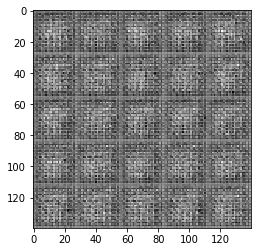

Epoch 0/2... Discriminator Loss: 0.0639... Generator Loss: 4.1375
Epoch 0/2... Discriminator Loss: 0.6111... Generator Loss: 2.6971
Epoch 0/2... Discriminator Loss: 0.8632... Generator Loss: 0.8320
Epoch 0/2... Discriminator Loss: 0.3593... Generator Loss: 3.4044
Epoch 0/2... Discriminator Loss: 0.3351... Generator Loss: 3.4187


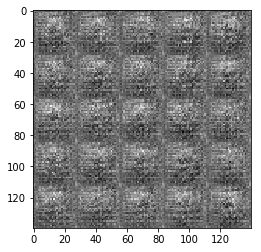

Epoch 0/2... Discriminator Loss: 0.1235... Generator Loss: 2.9318
Epoch 0/2... Discriminator Loss: 0.4186... Generator Loss: 1.5042
Epoch 0/2... Discriminator Loss: 0.2104... Generator Loss: 1.8143
Epoch 0/2... Discriminator Loss: 0.1033... Generator Loss: 2.9015
Epoch 0/2... Discriminator Loss: 0.0637... Generator Loss: 3.4049


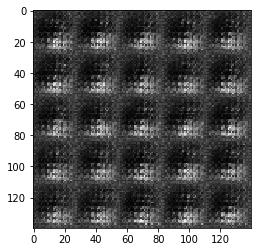

Epoch 0/2... Discriminator Loss: 0.0579... Generator Loss: 3.3572
Epoch 0/2... Discriminator Loss: 0.1080... Generator Loss: 2.9164
Epoch 0/2... Discriminator Loss: 0.0606... Generator Loss: 3.4963
Epoch 0/2... Discriminator Loss: 0.0513... Generator Loss: 3.6865
Epoch 0/2... Discriminator Loss: 0.1046... Generator Loss: 3.0393


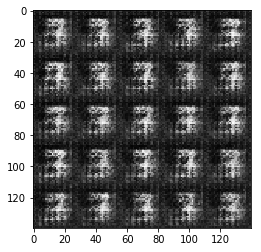

Epoch 0/2... Discriminator Loss: 0.0963... Generator Loss: 3.0856
Epoch 0/2... Discriminator Loss: 0.0481... Generator Loss: 4.1065
Epoch 0/2... Discriminator Loss: 0.0550... Generator Loss: 3.8303
Epoch 0/2... Discriminator Loss: 0.0646... Generator Loss: 3.5544
Epoch 0/2... Discriminator Loss: 0.0674... Generator Loss: 4.0633


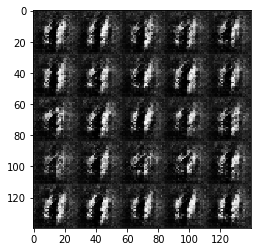

Epoch 0/2... Discriminator Loss: 0.1496... Generator Loss: 2.9075
Epoch 0/2... Discriminator Loss: 0.3552... Generator Loss: 4.2956
Epoch 0/2... Discriminator Loss: 1.0614... Generator Loss: 5.5346
Epoch 0/2... Discriminator Loss: 1.7811... Generator Loss: 0.3091
Epoch 0/2... Discriminator Loss: 0.5655... Generator Loss: 4.9912


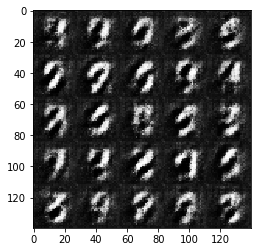

Epoch 0/2... Discriminator Loss: 0.3650... Generator Loss: 4.2119
Epoch 0/2... Discriminator Loss: 0.3832... Generator Loss: 1.7518
Epoch 0/2... Discriminator Loss: 0.2470... Generator Loss: 2.0586
Epoch 0/2... Discriminator Loss: 1.0620... Generator Loss: 0.5995
Epoch 0/2... Discriminator Loss: 0.3631... Generator Loss: 1.8671


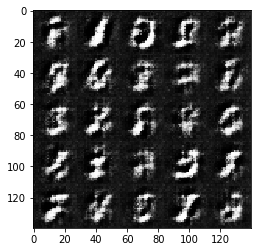

Epoch 0/2... Discriminator Loss: 0.2297... Generator Loss: 2.9841
Epoch 0/2... Discriminator Loss: 0.2202... Generator Loss: 2.7566
Epoch 0/2... Discriminator Loss: 0.8720... Generator Loss: 0.7058
Epoch 0/2... Discriminator Loss: 0.3930... Generator Loss: 2.0957
Epoch 0/2... Discriminator Loss: 0.3607... Generator Loss: 1.6824


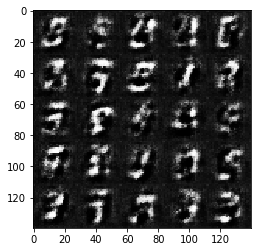

Epoch 0/2... Discriminator Loss: 0.2585... Generator Loss: 2.2447
Epoch 0/2... Discriminator Loss: 0.3986... Generator Loss: 1.5759
Epoch 0/2... Discriminator Loss: 0.7050... Generator Loss: 3.7420
Epoch 0/2... Discriminator Loss: 0.3909... Generator Loss: 2.0943
Epoch 0/2... Discriminator Loss: 0.3916... Generator Loss: 1.6774


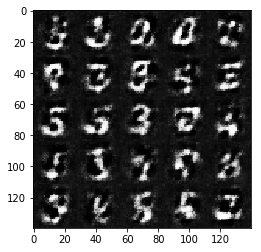

Epoch 0/2... Discriminator Loss: 0.5192... Generator Loss: 1.2105
Epoch 0/2... Discriminator Loss: 1.3303... Generator Loss: 5.5602
Epoch 0/2... Discriminator Loss: 0.4085... Generator Loss: 1.9686
Epoch 0/2... Discriminator Loss: 0.3321... Generator Loss: 2.3580
Epoch 0/2... Discriminator Loss: 0.5001... Generator Loss: 3.5933


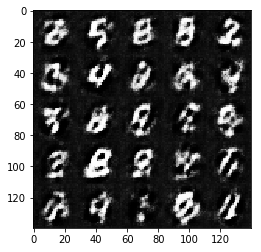

Epoch 0/2... Discriminator Loss: 0.3521... Generator Loss: 1.8957
Epoch 0/2... Discriminator Loss: 0.3330... Generator Loss: 1.7042
Epoch 0/2... Discriminator Loss: 0.5804... Generator Loss: 3.6475
Epoch 0/2... Discriminator Loss: 0.3153... Generator Loss: 2.1855
Epoch 0/2... Discriminator Loss: 0.3376... Generator Loss: 1.6217


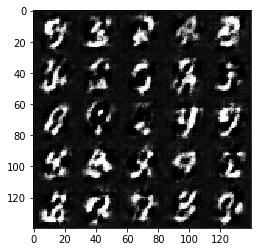

Epoch 0/2... Discriminator Loss: 0.2936... Generator Loss: 2.0156
Epoch 0/2... Discriminator Loss: 0.2919... Generator Loss: 1.9822
Epoch 0/2... Discriminator Loss: 0.3776... Generator Loss: 3.8141
Epoch 0/2... Discriminator Loss: 0.4867... Generator Loss: 1.2691
Epoch 0/2... Discriminator Loss: 0.2461... Generator Loss: 2.2418


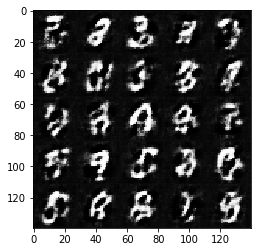

Epoch 0/2... Discriminator Loss: 0.2697... Generator Loss: 2.1327
Epoch 0/2... Discriminator Loss: 0.2465... Generator Loss: 2.0519
Epoch 0/2... Discriminator Loss: 0.6096... Generator Loss: 4.0620
Epoch 0/2... Discriminator Loss: 0.2862... Generator Loss: 2.2680
Epoch 0/2... Discriminator Loss: 0.2438... Generator Loss: 2.3212


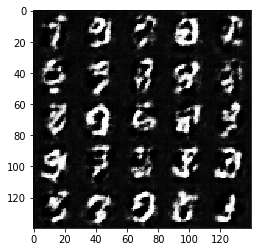

Epoch 0/2... Discriminator Loss: 0.2824... Generator Loss: 2.5702
Epoch 0/2... Discriminator Loss: 0.2286... Generator Loss: 2.5390
Epoch 0/2... Discriminator Loss: 0.4486... Generator Loss: 4.0000
Epoch 0/2... Discriminator Loss: 0.3316... Generator Loss: 2.2594
Epoch 0/2... Discriminator Loss: 0.5257... Generator Loss: 3.5523


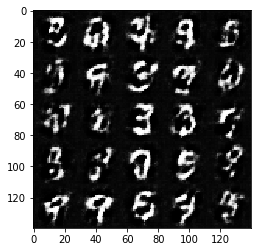

Epoch 0/2... Discriminator Loss: 0.3000... Generator Loss: 2.2129
Epoch 0/2... Discriminator Loss: 0.2863... Generator Loss: 2.8222
Epoch 0/2... Discriminator Loss: 0.8659... Generator Loss: 0.6871
Epoch 0/2... Discriminator Loss: 0.2904... Generator Loss: 2.0031
Epoch 0/2... Discriminator Loss: 0.2608... Generator Loss: 2.0211


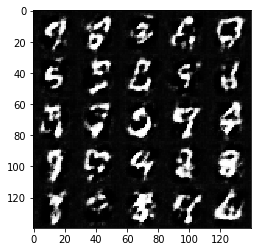

Epoch 0/2... Discriminator Loss: 0.3307... Generator Loss: 3.3729
Epoch 0/2... Discriminator Loss: 0.3092... Generator Loss: 1.8695
Epoch 0/2... Discriminator Loss: 0.2152... Generator Loss: 2.4917
Epoch 0/2... Discriminator Loss: 0.8139... Generator Loss: 0.8032
Epoch 0/2... Discriminator Loss: 0.5265... Generator Loss: 3.9762


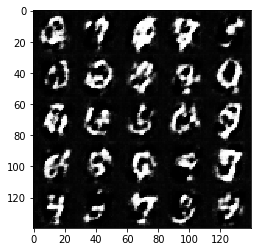

Epoch 0/2... Discriminator Loss: 0.3590... Generator Loss: 3.3387


KeyboardInterrupt: 

In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/3... Discriminator Loss: 0.5762... Generator Loss: 1.2568
Epoch 0/3... Discriminator Loss: 0.2799... Generator Loss: 1.8584
Epoch 0/3... Discriminator Loss: 0.2215... Generator Loss: 2.0918
Epoch 0/3... Discriminator Loss: 0.1952... Generator Loss: 2.2362
Epoch 0/3... Discriminator Loss: 0.1697... Generator Loss: 2.4893


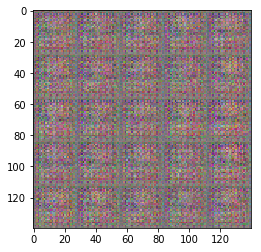

Epoch 0/3... Discriminator Loss: 0.1179... Generator Loss: 2.7192
Epoch 0/3... Discriminator Loss: 0.1216... Generator Loss: 3.2140
Epoch 0/3... Discriminator Loss: 0.0886... Generator Loss: 5.6010
Epoch 0/3... Discriminator Loss: 0.0943... Generator Loss: 3.0783
Epoch 0/3... Discriminator Loss: 0.1294... Generator Loss: 2.8746


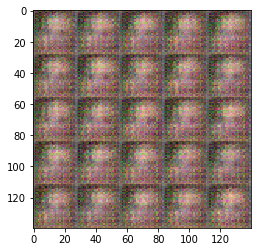

Epoch 0/3... Discriminator Loss: 1.2320... Generator Loss: 0.4322
Epoch 0/3... Discriminator Loss: 0.1540... Generator Loss: 3.3293
Epoch 0/3... Discriminator Loss: 0.1683... Generator Loss: 3.5246
Epoch 0/3... Discriminator Loss: 0.1695... Generator Loss: 4.3208
Epoch 0/3... Discriminator Loss: 0.1200... Generator Loss: 3.2033


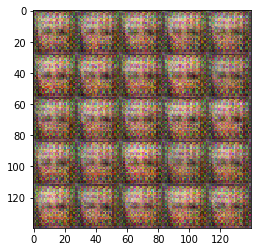

Epoch 0/3... Discriminator Loss: 0.1985... Generator Loss: 3.0675
Epoch 0/3... Discriminator Loss: 0.1577... Generator Loss: 2.5561
Epoch 0/3... Discriminator Loss: 0.1155... Generator Loss: 3.3367
Epoch 0/3... Discriminator Loss: 0.4498... Generator Loss: 8.1568
Epoch 0/3... Discriminator Loss: 0.1409... Generator Loss: 2.6211


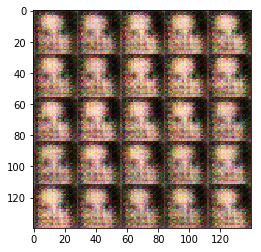

Epoch 0/3... Discriminator Loss: 0.3455... Generator Loss: 1.6556
Epoch 0/3... Discriminator Loss: 0.3863... Generator Loss: 1.3118
Epoch 0/3... Discriminator Loss: 0.2657... Generator Loss: 1.7694
Epoch 0/3... Discriminator Loss: 0.2090... Generator Loss: 5.1117
Epoch 0/3... Discriminator Loss: 0.1275... Generator Loss: 5.2076


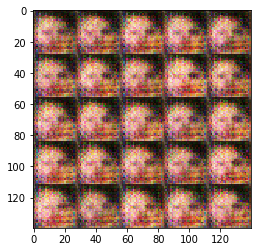

Epoch 0/3... Discriminator Loss: 0.0959... Generator Loss: 5.2004
Epoch 0/3... Discriminator Loss: 0.0880... Generator Loss: 3.2462
Epoch 0/3... Discriminator Loss: 0.1717... Generator Loss: 2.7582
Epoch 0/3... Discriminator Loss: 0.0539... Generator Loss: 4.4181
Epoch 0/3... Discriminator Loss: 0.0732... Generator Loss: 3.3148


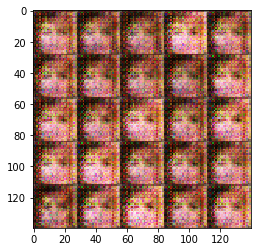

Epoch 0/3... Discriminator Loss: 0.1695... Generator Loss: 2.3883
Epoch 0/3... Discriminator Loss: 0.2066... Generator Loss: 6.3012
Epoch 0/3... Discriminator Loss: 0.1991... Generator Loss: 2.6892
Epoch 0/3... Discriminator Loss: 0.4690... Generator Loss: 1.8550
Epoch 0/3... Discriminator Loss: 0.2162... Generator Loss: 2.4723


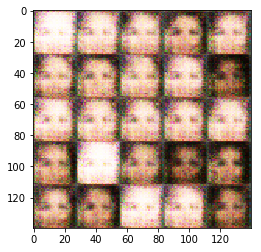

Epoch 0/3... Discriminator Loss: 1.4174... Generator Loss: 6.9554
Epoch 0/3... Discriminator Loss: 0.4246... Generator Loss: 1.5726
Epoch 0/3... Discriminator Loss: 0.2621... Generator Loss: 2.2310
Epoch 0/3... Discriminator Loss: 0.2720... Generator Loss: 5.0599
Epoch 0/3... Discriminator Loss: 0.2769... Generator Loss: 2.8709


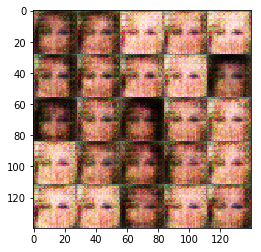

Epoch 0/3... Discriminator Loss: 0.2069... Generator Loss: 2.6935
Epoch 0/3... Discriminator Loss: 0.5138... Generator Loss: 1.0765
Epoch 0/3... Discriminator Loss: 0.1368... Generator Loss: 3.8567
Epoch 0/3... Discriminator Loss: 0.4606... Generator Loss: 1.3089
Epoch 0/3... Discriminator Loss: 0.2911... Generator Loss: 3.8640


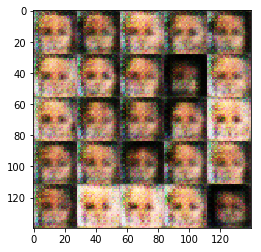

Epoch 0/3... Discriminator Loss: 0.3823... Generator Loss: 1.6413
Epoch 0/3... Discriminator Loss: 0.3266... Generator Loss: 2.7346
Epoch 0/3... Discriminator Loss: 0.2321... Generator Loss: 2.0913
Epoch 0/3... Discriminator Loss: 0.2852... Generator Loss: 2.9690
Epoch 0/3... Discriminator Loss: 0.2144... Generator Loss: 2.5102


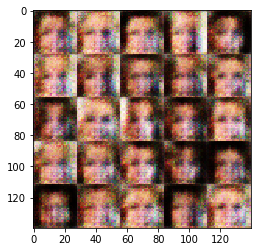

Epoch 0/3... Discriminator Loss: 0.3262... Generator Loss: 1.8353
Epoch 0/3... Discriminator Loss: 0.2881... Generator Loss: 2.7022
Epoch 0/3... Discriminator Loss: 0.2721... Generator Loss: 2.0180
Epoch 0/3... Discriminator Loss: 0.9560... Generator Loss: 0.7032
Epoch 0/3... Discriminator Loss: 0.4110... Generator Loss: 1.6534


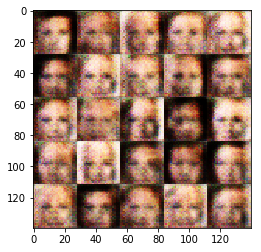

Epoch 0/3... Discriminator Loss: 0.3328... Generator Loss: 2.5906
Epoch 0/3... Discriminator Loss: 0.3103... Generator Loss: 2.5576
Epoch 0/3... Discriminator Loss: 0.3706... Generator Loss: 3.6986
Epoch 0/3... Discriminator Loss: 0.2757... Generator Loss: 3.1740
Epoch 0/3... Discriminator Loss: 0.3316... Generator Loss: 1.7567


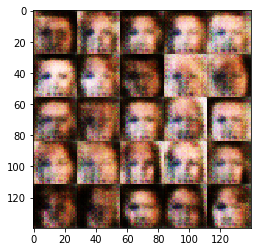

Epoch 0/3... Discriminator Loss: 0.7253... Generator Loss: 6.5584
Epoch 0/3... Discriminator Loss: 0.1716... Generator Loss: 2.9176
Epoch 0/3... Discriminator Loss: 0.3817... Generator Loss: 1.8087
Epoch 0/3... Discriminator Loss: 0.2887... Generator Loss: 3.1210
Epoch 0/3... Discriminator Loss: 0.3848... Generator Loss: 2.0322


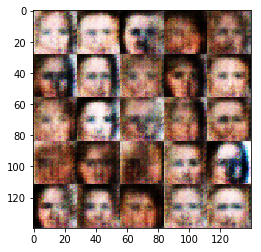

Epoch 0/3... Discriminator Loss: 0.3654... Generator Loss: 2.2413
Epoch 0/3... Discriminator Loss: 0.4533... Generator Loss: 1.3434
Epoch 0/3... Discriminator Loss: 0.3181... Generator Loss: 1.9570
Epoch 0/3... Discriminator Loss: 0.3781... Generator Loss: 2.0159
Epoch 0/3... Discriminator Loss: 0.4058... Generator Loss: 1.9033


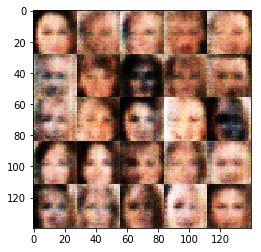

Epoch 0/3... Discriminator Loss: 0.3706... Generator Loss: 1.9528
Epoch 0/3... Discriminator Loss: 0.2800... Generator Loss: 2.9580
Epoch 0/3... Discriminator Loss: 0.3190... Generator Loss: 2.0852
Epoch 0/3... Discriminator Loss: 0.3736... Generator Loss: 1.7400
Epoch 0/3... Discriminator Loss: 0.5177... Generator Loss: 2.9718


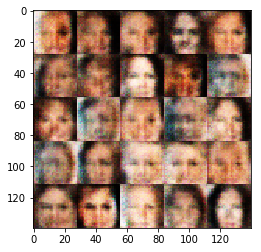

Epoch 0/3... Discriminator Loss: 0.3139... Generator Loss: 2.5369
Epoch 0/3... Discriminator Loss: 0.3414... Generator Loss: 1.8960
Epoch 0/3... Discriminator Loss: 0.3026... Generator Loss: 2.5131
Epoch 0/3... Discriminator Loss: 2.1760... Generator Loss: 6.4120
Epoch 0/3... Discriminator Loss: 0.4529... Generator Loss: 1.9194


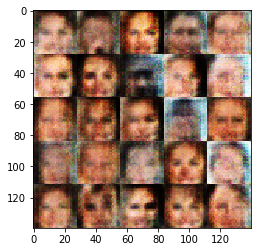

Epoch 0/3... Discriminator Loss: 0.4019... Generator Loss: 3.1483
Epoch 0/3... Discriminator Loss: 0.4577... Generator Loss: 3.2316
Epoch 0/3... Discriminator Loss: 0.4291... Generator Loss: 3.0687
Epoch 0/3... Discriminator Loss: 0.4070... Generator Loss: 1.7454
Epoch 0/3... Discriminator Loss: 0.4910... Generator Loss: 2.6418


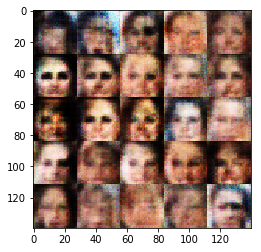

Epoch 0/3... Discriminator Loss: 0.7144... Generator Loss: 4.2556
Epoch 0/3... Discriminator Loss: 0.4454... Generator Loss: 1.3774
Epoch 0/3... Discriminator Loss: 0.4231... Generator Loss: 1.6254
Epoch 0/3... Discriminator Loss: 0.5579... Generator Loss: 2.8610
Epoch 0/3... Discriminator Loss: 0.4413... Generator Loss: 3.1906


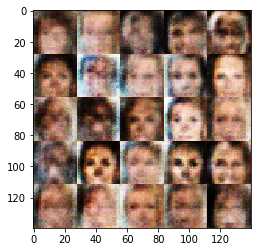

Epoch 0/3... Discriminator Loss: 0.5926... Generator Loss: 3.3684
Epoch 0/3... Discriminator Loss: 1.0029... Generator Loss: 0.6163
Epoch 0/3... Discriminator Loss: 0.6448... Generator Loss: 3.7259
Epoch 0/3... Discriminator Loss: 0.4593... Generator Loss: 1.7112
Epoch 0/3... Discriminator Loss: 0.5114... Generator Loss: 1.2842


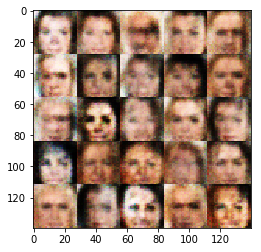

Epoch 0/3... Discriminator Loss: 0.4842... Generator Loss: 2.8600
Epoch 0/3... Discriminator Loss: 0.4494... Generator Loss: 1.7982
Epoch 0/3... Discriminator Loss: 0.5140... Generator Loss: 2.5640
Epoch 0/3... Discriminator Loss: 0.3815... Generator Loss: 1.6552
Epoch 0/3... Discriminator Loss: 0.9466... Generator Loss: 0.6545


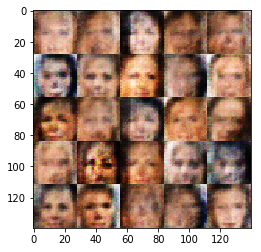

Epoch 0/3... Discriminator Loss: 0.6231... Generator Loss: 1.0550
Epoch 0/3... Discriminator Loss: 0.4479... Generator Loss: 1.5668
Epoch 0/3... Discriminator Loss: 0.4639... Generator Loss: 1.7872
Epoch 0/3... Discriminator Loss: 0.4753... Generator Loss: 1.4352
Epoch 0/3... Discriminator Loss: 0.3748... Generator Loss: 1.9335


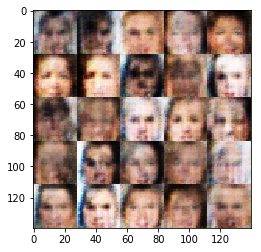

Epoch 0/3... Discriminator Loss: 0.8403... Generator Loss: 3.6346
Epoch 0/3... Discriminator Loss: 0.8878... Generator Loss: 0.7712
Epoch 0/3... Discriminator Loss: 0.6449... Generator Loss: 1.0367
Epoch 0/3... Discriminator Loss: 0.7490... Generator Loss: 0.9575
Epoch 0/3... Discriminator Loss: 0.6181... Generator Loss: 2.5721


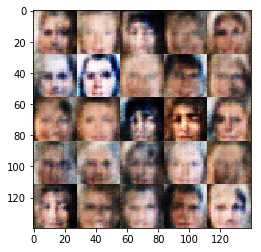

Epoch 0/3... Discriminator Loss: 0.5554... Generator Loss: 1.2193
Epoch 0/3... Discriminator Loss: 0.4618... Generator Loss: 3.7427
Epoch 0/3... Discriminator Loss: 0.6282... Generator Loss: 1.0487
Epoch 0/3... Discriminator Loss: 0.4176... Generator Loss: 1.7548
Epoch 0/3... Discriminator Loss: 0.5045... Generator Loss: 1.3427


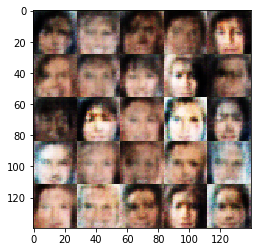

Epoch 0/3... Discriminator Loss: 0.6021... Generator Loss: 0.9868
Epoch 0/3... Discriminator Loss: 0.4642... Generator Loss: 1.9488
Epoch 0/3... Discriminator Loss: 0.6573... Generator Loss: 1.0623
Epoch 0/3... Discriminator Loss: 0.4554... Generator Loss: 1.6195
Epoch 0/3... Discriminator Loss: 0.9856... Generator Loss: 0.6218


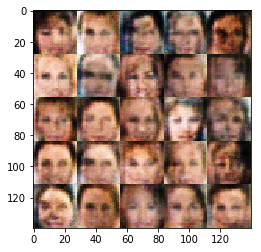

Epoch 0/3... Discriminator Loss: 0.6100... Generator Loss: 1.0213
Epoch 0/3... Discriminator Loss: 0.5647... Generator Loss: 1.1710
Epoch 0/3... Discriminator Loss: 0.8915... Generator Loss: 0.6863
Epoch 0/3... Discriminator Loss: 0.6937... Generator Loss: 2.6950
Epoch 0/3... Discriminator Loss: 0.7468... Generator Loss: 0.8830


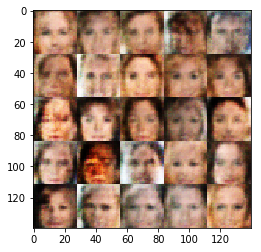

Epoch 0/3... Discriminator Loss: 1.4407... Generator Loss: 0.3557
Epoch 0/3... Discriminator Loss: 1.1924... Generator Loss: 0.4717
Epoch 0/3... Discriminator Loss: 0.6256... Generator Loss: 2.1274
Epoch 0/3... Discriminator Loss: 0.5520... Generator Loss: 1.7654
Epoch 0/3... Discriminator Loss: 0.6103... Generator Loss: 1.2378


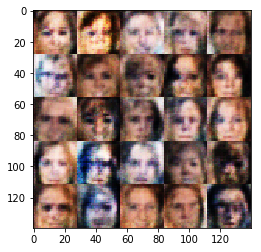

Epoch 0/3... Discriminator Loss: 0.6458... Generator Loss: 2.3444
Epoch 0/3... Discriminator Loss: 0.7634... Generator Loss: 3.1563
Epoch 0/3... Discriminator Loss: 0.5418... Generator Loss: 1.8794
Epoch 0/3... Discriminator Loss: 0.6128... Generator Loss: 2.4718
Epoch 0/3... Discriminator Loss: 0.9801... Generator Loss: 2.9515


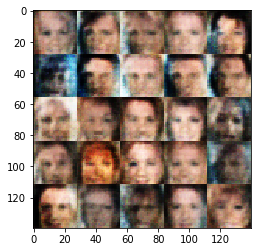

Epoch 0/3... Discriminator Loss: 0.6728... Generator Loss: 1.9487
Epoch 0/3... Discriminator Loss: 0.6225... Generator Loss: 1.2904
Epoch 0/3... Discriminator Loss: 0.5909... Generator Loss: 3.0425
Epoch 0/3... Discriminator Loss: 0.6073... Generator Loss: 2.5679
Epoch 0/3... Discriminator Loss: 0.6374... Generator Loss: 2.2641


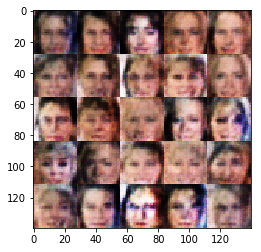

Epoch 0/3... Discriminator Loss: 0.6680... Generator Loss: 1.5789
Epoch 0/3... Discriminator Loss: 0.5671... Generator Loss: 1.7148
Epoch 0/3... Discriminator Loss: 0.6614... Generator Loss: 1.1359
Epoch 0/3... Discriminator Loss: 0.6816... Generator Loss: 1.1713
Epoch 0/3... Discriminator Loss: 0.8086... Generator Loss: 0.8211


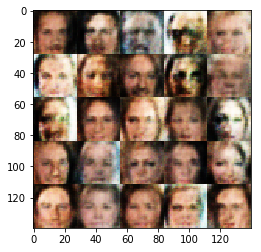

Epoch 0/3... Discriminator Loss: 0.5916... Generator Loss: 1.7337
Epoch 0/3... Discriminator Loss: 0.5303... Generator Loss: 1.4561
Epoch 0/3... Discriminator Loss: 0.5487... Generator Loss: 1.6376
Epoch 0/3... Discriminator Loss: 0.7861... Generator Loss: 2.7034
Epoch 0/3... Discriminator Loss: 0.8711... Generator Loss: 1.9883


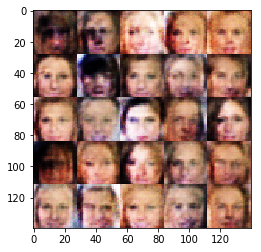

Epoch 0/3... Discriminator Loss: 0.5635... Generator Loss: 1.8051
Epoch 0/3... Discriminator Loss: 0.6258... Generator Loss: 1.2359
Epoch 0/3... Discriminator Loss: 0.8098... Generator Loss: 0.8325
Epoch 0/3... Discriminator Loss: 0.6715... Generator Loss: 1.1127
Epoch 0/3... Discriminator Loss: 0.6211... Generator Loss: 2.0045


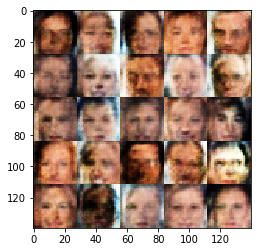

Epoch 0/3... Discriminator Loss: 1.1333... Generator Loss: 0.5408
Epoch 0/3... Discriminator Loss: 0.7022... Generator Loss: 2.5903
Epoch 0/3... Discriminator Loss: 0.7007... Generator Loss: 0.9735
Epoch 0/3... Discriminator Loss: 0.6725... Generator Loss: 1.0696
Epoch 0/3... Discriminator Loss: 0.6593... Generator Loss: 1.0444


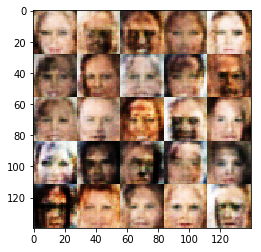

Epoch 0/3... Discriminator Loss: 0.8985... Generator Loss: 2.6651
Epoch 0/3... Discriminator Loss: 0.5692... Generator Loss: 1.2202
Epoch 0/3... Discriminator Loss: 0.7185... Generator Loss: 1.0685
Epoch 0/3... Discriminator Loss: 0.8287... Generator Loss: 0.9529
Epoch 0/3... Discriminator Loss: 0.9532... Generator Loss: 0.6758


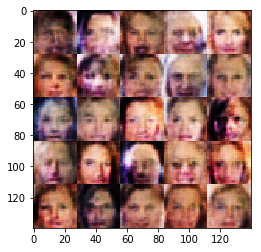

Epoch 0/3... Discriminator Loss: 0.6293... Generator Loss: 1.2396
Epoch 0/3... Discriminator Loss: 1.0252... Generator Loss: 3.4258
Epoch 0/3... Discriminator Loss: 0.6177... Generator Loss: 1.5703
Epoch 0/3... Discriminator Loss: 0.8024... Generator Loss: 0.8169
Epoch 0/3... Discriminator Loss: 0.7042... Generator Loss: 1.0258


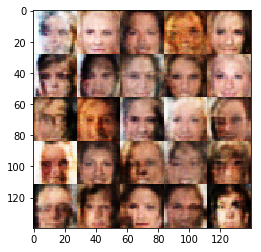

Epoch 0/3... Discriminator Loss: 0.7034... Generator Loss: 1.1096
Epoch 0/3... Discriminator Loss: 0.8033... Generator Loss: 0.7559
Epoch 0/3... Discriminator Loss: 0.6256... Generator Loss: 1.3053
Epoch 0/3... Discriminator Loss: 0.4989... Generator Loss: 1.5554
Epoch 0/3... Discriminator Loss: 0.6159... Generator Loss: 1.5018


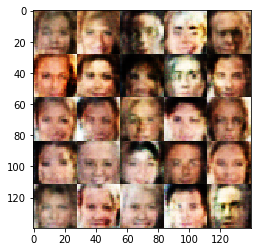

Epoch 0/3... Discriminator Loss: 0.7396... Generator Loss: 1.6307
Epoch 0/3... Discriminator Loss: 0.6639... Generator Loss: 2.1730
Epoch 0/3... Discriminator Loss: 0.5694... Generator Loss: 1.8177
Epoch 0/3... Discriminator Loss: 0.5871... Generator Loss: 1.3739
Epoch 0/3... Discriminator Loss: 0.5914... Generator Loss: 1.2429


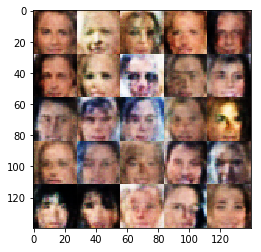

Epoch 0/3... Discriminator Loss: 0.7436... Generator Loss: 0.9798
Epoch 0/3... Discriminator Loss: 0.5862... Generator Loss: 1.8320
Epoch 0/3... Discriminator Loss: 0.5794... Generator Loss: 1.7198
Epoch 0/3... Discriminator Loss: 0.7380... Generator Loss: 0.9637
Epoch 0/3... Discriminator Loss: 0.5857... Generator Loss: 2.4822


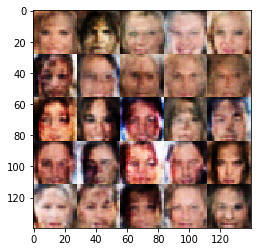

Epoch 0/3... Discriminator Loss: 0.6799... Generator Loss: 2.6296
Epoch 0/3... Discriminator Loss: 0.7895... Generator Loss: 1.6912
Epoch 0/3... Discriminator Loss: 1.0458... Generator Loss: 0.5802
Epoch 0/3... Discriminator Loss: 0.5163... Generator Loss: 1.6917
Epoch 0/3... Discriminator Loss: 0.6697... Generator Loss: 1.0551


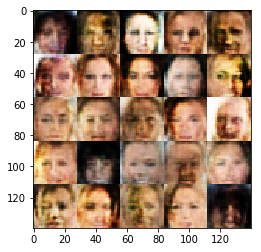

Epoch 0/3... Discriminator Loss: 0.8896... Generator Loss: 2.8202
Epoch 0/3... Discriminator Loss: 1.1275... Generator Loss: 0.5188
Epoch 0/3... Discriminator Loss: 0.8625... Generator Loss: 0.7039
Epoch 0/3... Discriminator Loss: 0.5281... Generator Loss: 1.4043
Epoch 0/3... Discriminator Loss: 0.7125... Generator Loss: 0.9292


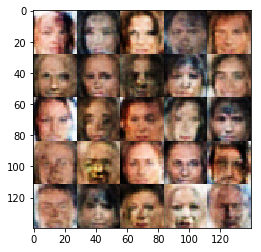

KeyboardInterrupt: 

In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.